# 08 MNIST experiment
An experiment consisting of such steps:
1. Create a toy MNIST problem classifying only between 0 and 8.
2. Train a CNN classifier on the data
3. generate an attribution map of the classifier (should focus somewhere to the center)
4. Check if the attribution maps are correct. If false, use RRR to fix them.

The main goal of this experiment is to smoothly introduce usage of RRR as well as show usefulness of the algorithm

## 1.1 Dataset preparation

In [91]:
%matplotlib inline
import numpy
import torchvision.datasets as tds
from IPython.core.pylabtools import figsize
from torchvision.transforms import ToTensor, Lambda
import torch

num_classes = 2

ds_train = tds.MNIST(
    root="data/",
    train=True,
    download=True,
    transform=ToTensor(),
    # target_transform=Lambda(lambda y: torch.zeros(2, dtype=torch.float).scatter_(0, torch.tensor(0 if y == 0 else 1 if y == 8 else 2), value=1)) 
)

# target transformation according to "output: 3 possible outputs (0: out of problem label, 1: number 0, 2: number 8)"
ds_test = tds.MNIST(
    root="data/",
    train=False,
    download=True,
    transform=ToTensor(),
    # target_transform=Lambda(lambda y: torch.zeros(2, dtype=torch.float).scatter_(0, torch.tensor(0 if y == 0 else 1 if y == 8 else 2), value=1))
)

train_dataset_length = -1

labels = [0, 8]
train_indices = [i for i, (_, label) in enumerate(ds_train) if label in labels][:train_dataset_length]
test_indices = [i for i, (_, label) in enumerate(ds_test) if label in labels]
ds_train = torch.utils.data.Subset(ds_train, train_indices)
ds_test = torch.utils.data.Subset(ds_test, test_indices)

# Set target_transform attribute
target_transform = Lambda(lambda y: torch.zeros(2, dtype=torch.float).scatter_(0, torch.tensor(0 if y == 0 else 1), value=1))
ds_train.dataset.target_transform = target_transform
ds_test.dataset.target_transform = target_transform


Length of ds_train: 11773; length of ds_test: 1954
shape of x[0]: torch.Size([1, 28, 28])
y[0]: tensor([1., 0.])


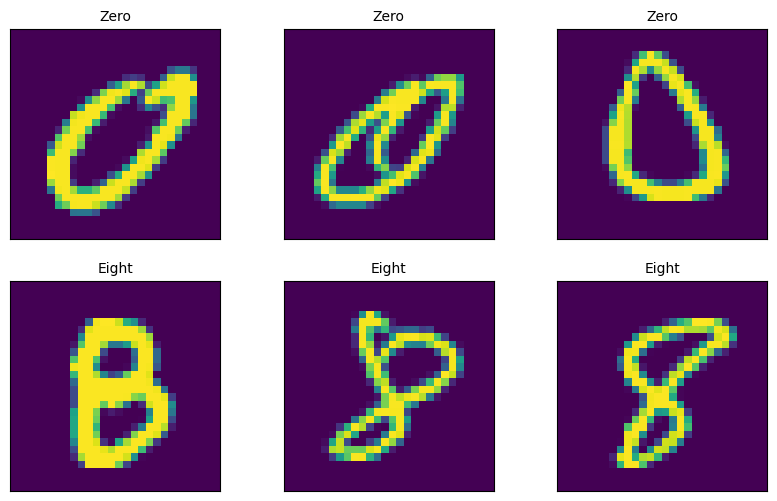

In [92]:
print(f"Length of ds_train: {len(ds_train)}; length of ds_test: {len(ds_test)}")
first = ds_train[0]
first_x = first[0]
print("shape of x[0]:", first_x.shape)
print("y[0]:", first[1])
size_1_dim = first_x.shape[1] * first_x.shape[2]

import matplotlib.pyplot as plt
fig, ax_list = plt.subplots(nrows=2, ncols=3, figsize=(10, 6))
# fig.subplots_adjust(wspace=0, hspace=0)

# Show 3 instances for each of the 2 labels
label_translation = dict(zero=torch.tensor((1, 0)), eight=torch.tensor((0, 1)))
zeros = []
eights = []
example_dataloader = torch.utils.data.DataLoader(ds_train, batch_size=1, shuffle=True)
for i, (X, y) in enumerate(example_dataloader):
    X = torch.flatten(X, 0, 2)
    if all(y[0] == label_translation["zero"]) and len(zeros) != 3:
        zeros.append(X)
    elif all(y[0] == label_translation["eight"]) and len(eights) != 3:
        eights.append(X)
    
    if len(zeros) == 3 and len(eights) == 3:
        break
    
for i, X in enumerate(zeros):
    ax_list[0][i].imshow(X, cmap='viridis')
    ax_list[0][i].set_title("Zero", fontsize=10, color='black')
    ax_list[0][i].set_xticks([])
    ax_list[0][i].set_yticks([])
    # ax_list[0][i].set_facecolor('black')

for i, X in enumerate(eights):
    ax_list[1][i].imshow(X, cmap='viridis')
    ax_list[1][i].set_title("Eight", fontsize=10, color='black')
    ax_list[1][i].set_xticks([])
    ax_list[1][i].set_yticks([])
    # ax_list[1][i].set_facecolor('black')

## 1.2 CNN definition

In [93]:
from torch.nn import Sequential, Conv2d, MaxPool2d, Flatten, ReLU, Linear, Dropout, Softmax

# input: 28X28 images
# output: 3 possible outputs (0: out of problem label, 1: number 0, 2: number 1)

model = Sequential(
    # 1st group
    Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1),
    ReLU(),
    MaxPool2d(kernel_size=2, stride=2),
    # 2nd group
    Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
    ReLU(),
    MaxPool2d(kernel_size=2, stride=2),
    # TODO: maybe 3rd group
    # Flattening into 1d array
    Flatten(),
    # Dense layers (aka Fully-connected layers)
    Linear(in_features=32 * 7 * 7, out_features=128), # maxpooling reduces dimensionality by half, 7 = 28 (image_size) / (2 * 2)
    ReLU(),
    Linear(in_features=128, out_features=num_classes),
    Softmax(dim=1)
)
# model.eval()



In [7]:
from torch.utils.data import DataLoader
from src.utils import XILUtils
t_dl = DataLoader(ds_train, batch_size=4)
device = XILUtils.define_device()
print(device)
test_model = model.to(device)
for batch, (X, y) in enumerate(t_dl):
    X = X.to(device)
    y = y.to(device)
    print(X.device, y.device)
    print(X, y)
    print(f"Shape of X: {X.shape}, shape of y: {y.shape}")
    test_model.eval()
    output = test_model(X)
    print(output.shape)
    print(output)
    break

mps
mps:0 mps:0
tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0

## 1.3 Training on MNIST dataset


In [94]:
import torch.nn.functional as F
def test_loop(dataloader, model, loss_fn, device):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            # move X, y to device
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (F.one_hot(pred.argmax(1), num_classes=num_classes) == y).type(torch.float).sum().item() / num_classes

        test_loss /= num_batches
        correct /= size
        print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")


In [95]:
from src.utils import XILUtils, ModelConfig
from torch.utils.data import DataLoader
from torch.optim import Adam, SGD
import torch.nn as nn

# move to the best device
device = XILUtils.define_device()
model = model.to(device)

# TODO: Try out both Adam and SGD
lr = 0.001
# lr = 0.0001
batch_size = 64

# define optimizers
sgd_opt = SGD(model.parameters(), lr=lr, momentum=0.9)
adam_opt = Adam(model.parameters(), lr=lr)

# define loss function
#   data imbalance prevention
# class_weights = torch.tensor([0.02, 0.45, 0.45], dtype=torch.float32).to(device)
loss = nn.CrossEntropyLoss()

# create dataloader
train_dataloader = DataLoader(ds_train, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(ds_test, batch_size=batch_size, shuffle=True)

# model config
conf = ModelConfig(batch_size=batch_size)


epochs = 1

for t in range(epochs):
    print(f"Epoch {t + 1}\n" + 20 * "-")
    
    # train loop 
    XILUtils.train_loop(train_dataloader, model, loss_fn=loss, optimizer=adam_opt, model_config=conf, device=device)
    
    # Evaluate the model
    test_loop(test_dataloader, model, loss_fn=loss, device=device)

print("Done!")


Epoch 1
--------------------
loss: 0.690607 [   64/11773]
loss: 0.333857 [ 6464/11773]
Test Error: 
 Accuracy: 99.0%, Avg loss: 0.323099 

Done!


## 1.4 Applying grad-cam

In [56]:
params = model.parameters
print(params)
model.eval()

<bound method Module.parameters of Sequential(
  (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=1568, out_features=128, bias=True)
  (8): ReLU()
  (9): Linear(in_features=128, out_features=2, bias=True)
  (10): Softmax(dim=1)
)>


Sequential(
  (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=1568, out_features=128, bias=True)
  (8): ReLU()
  (9): Linear(in_features=128, out_features=2, bias=True)
  (10): Softmax(dim=1)
)

Shape of example: torch.Size([1, 28, 28])
Target of example: tensor([0., 1.])

 Predicted target: tensor([0., 1.]) with 99.64997100830078% certainty. Correct? True

Properties of grayscale_cam. Type: <class 'numpy.ndarray'>, shape: (1, 28, 28).
Cam image shape: (28, 28, 3)


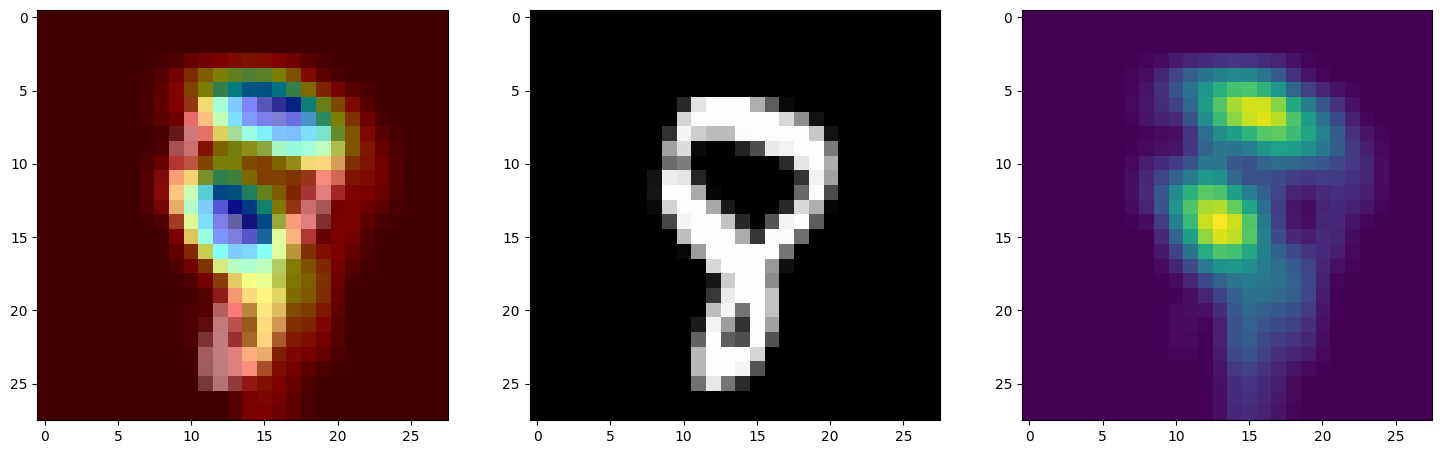

In [96]:
# First version of grad cam application

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import numpy

# define model
# model
# define target layers for grad-cam
#   define a link to the last convolutional layer of the model
last_conv_layer = model[3]
target_layers = [last_conv_layer]

# define input tensor
gradcam_dataloader = DataLoader(ds_train, batch_size=1, shuffle=True)
batch = next(iter(gradcam_dataloader))
examples = batch[0]
targets = batch[1]

index = 0

example = examples[index]
# example.unsqueeze_(0)
target = targets[index]
prediction_probs = model(example.unsqueeze(0).to(device))
prediction = torch.zeros(num_classes)
prediction[prediction_probs.argmax()] = 1
print(f"Shape of example: {example.shape}")
print(f"Target of example: {target}")
print(f"\n Predicted target: {prediction} with {prediction_probs.max() * 100}% certainty. Correct? {all(prediction == target)}\n")

input_tensor = examples
img: numpy.ndarray = example.reshape((28, 28, 1)).repeat(1, 1, 3).numpy()

# targets? TODO
targets = None

with GradCAM(model=model, target_layers=target_layers) as cam:
    
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets, aug_smooth=None, eigen_smooth=None)
    
    print(f"Properties of grayscale_cam. Type: {type(grayscale_cam)}, shape: {grayscale_cam.shape}.")
    grayscale_cam = grayscale_cam[0, :]
    
    cam_image = show_cam_on_image(img, grayscale_cam, use_rgb=False)

print(f"Cam image shape: {cam_image.shape}")
fig, ax_list = plt.subplots(nrows=1, ncols=3, figsize=(18, 10))
axes1 = ax_list[0]
axes2 = ax_list[1]
axes3 = ax_list[2]
axes1.imshow(cam_image, cmap='viridis')
axes2.imshow(img, cmap='viridis')
axes3.imshow(grayscale_cam)



Example 0:
Shape of example: torch.Size([1, 28, 28])
Target of example: tensor([0., 1.])
Predicted target: tensor([0., 1.]) with 99.99940395355225% certainty. Correct? True

Example 1:
Shape of example: torch.Size([1, 28, 28])
Target of example: tensor([0., 1.])
Predicted target: tensor([0., 1.]) with 99.99886751174927% certainty. Correct? True

Example 2:
Shape of example: torch.Size([1, 28, 28])
Target of example: tensor([1., 0.])
Predicted target: tensor([1., 0.]) with 100.0% certainty. Correct? True

Example 3:
Shape of example: torch.Size([1, 28, 28])
Target of example: tensor([0., 1.])
Predicted target: tensor([0., 1.]) with 99.99911785125732% certainty. Correct? True

Example 4:
Shape of example: torch.Size([1, 28, 28])
Target of example: tensor([1., 0.])
Predicted target: tensor([1., 0.]) with 99.99988079071045% certainty. Correct? True


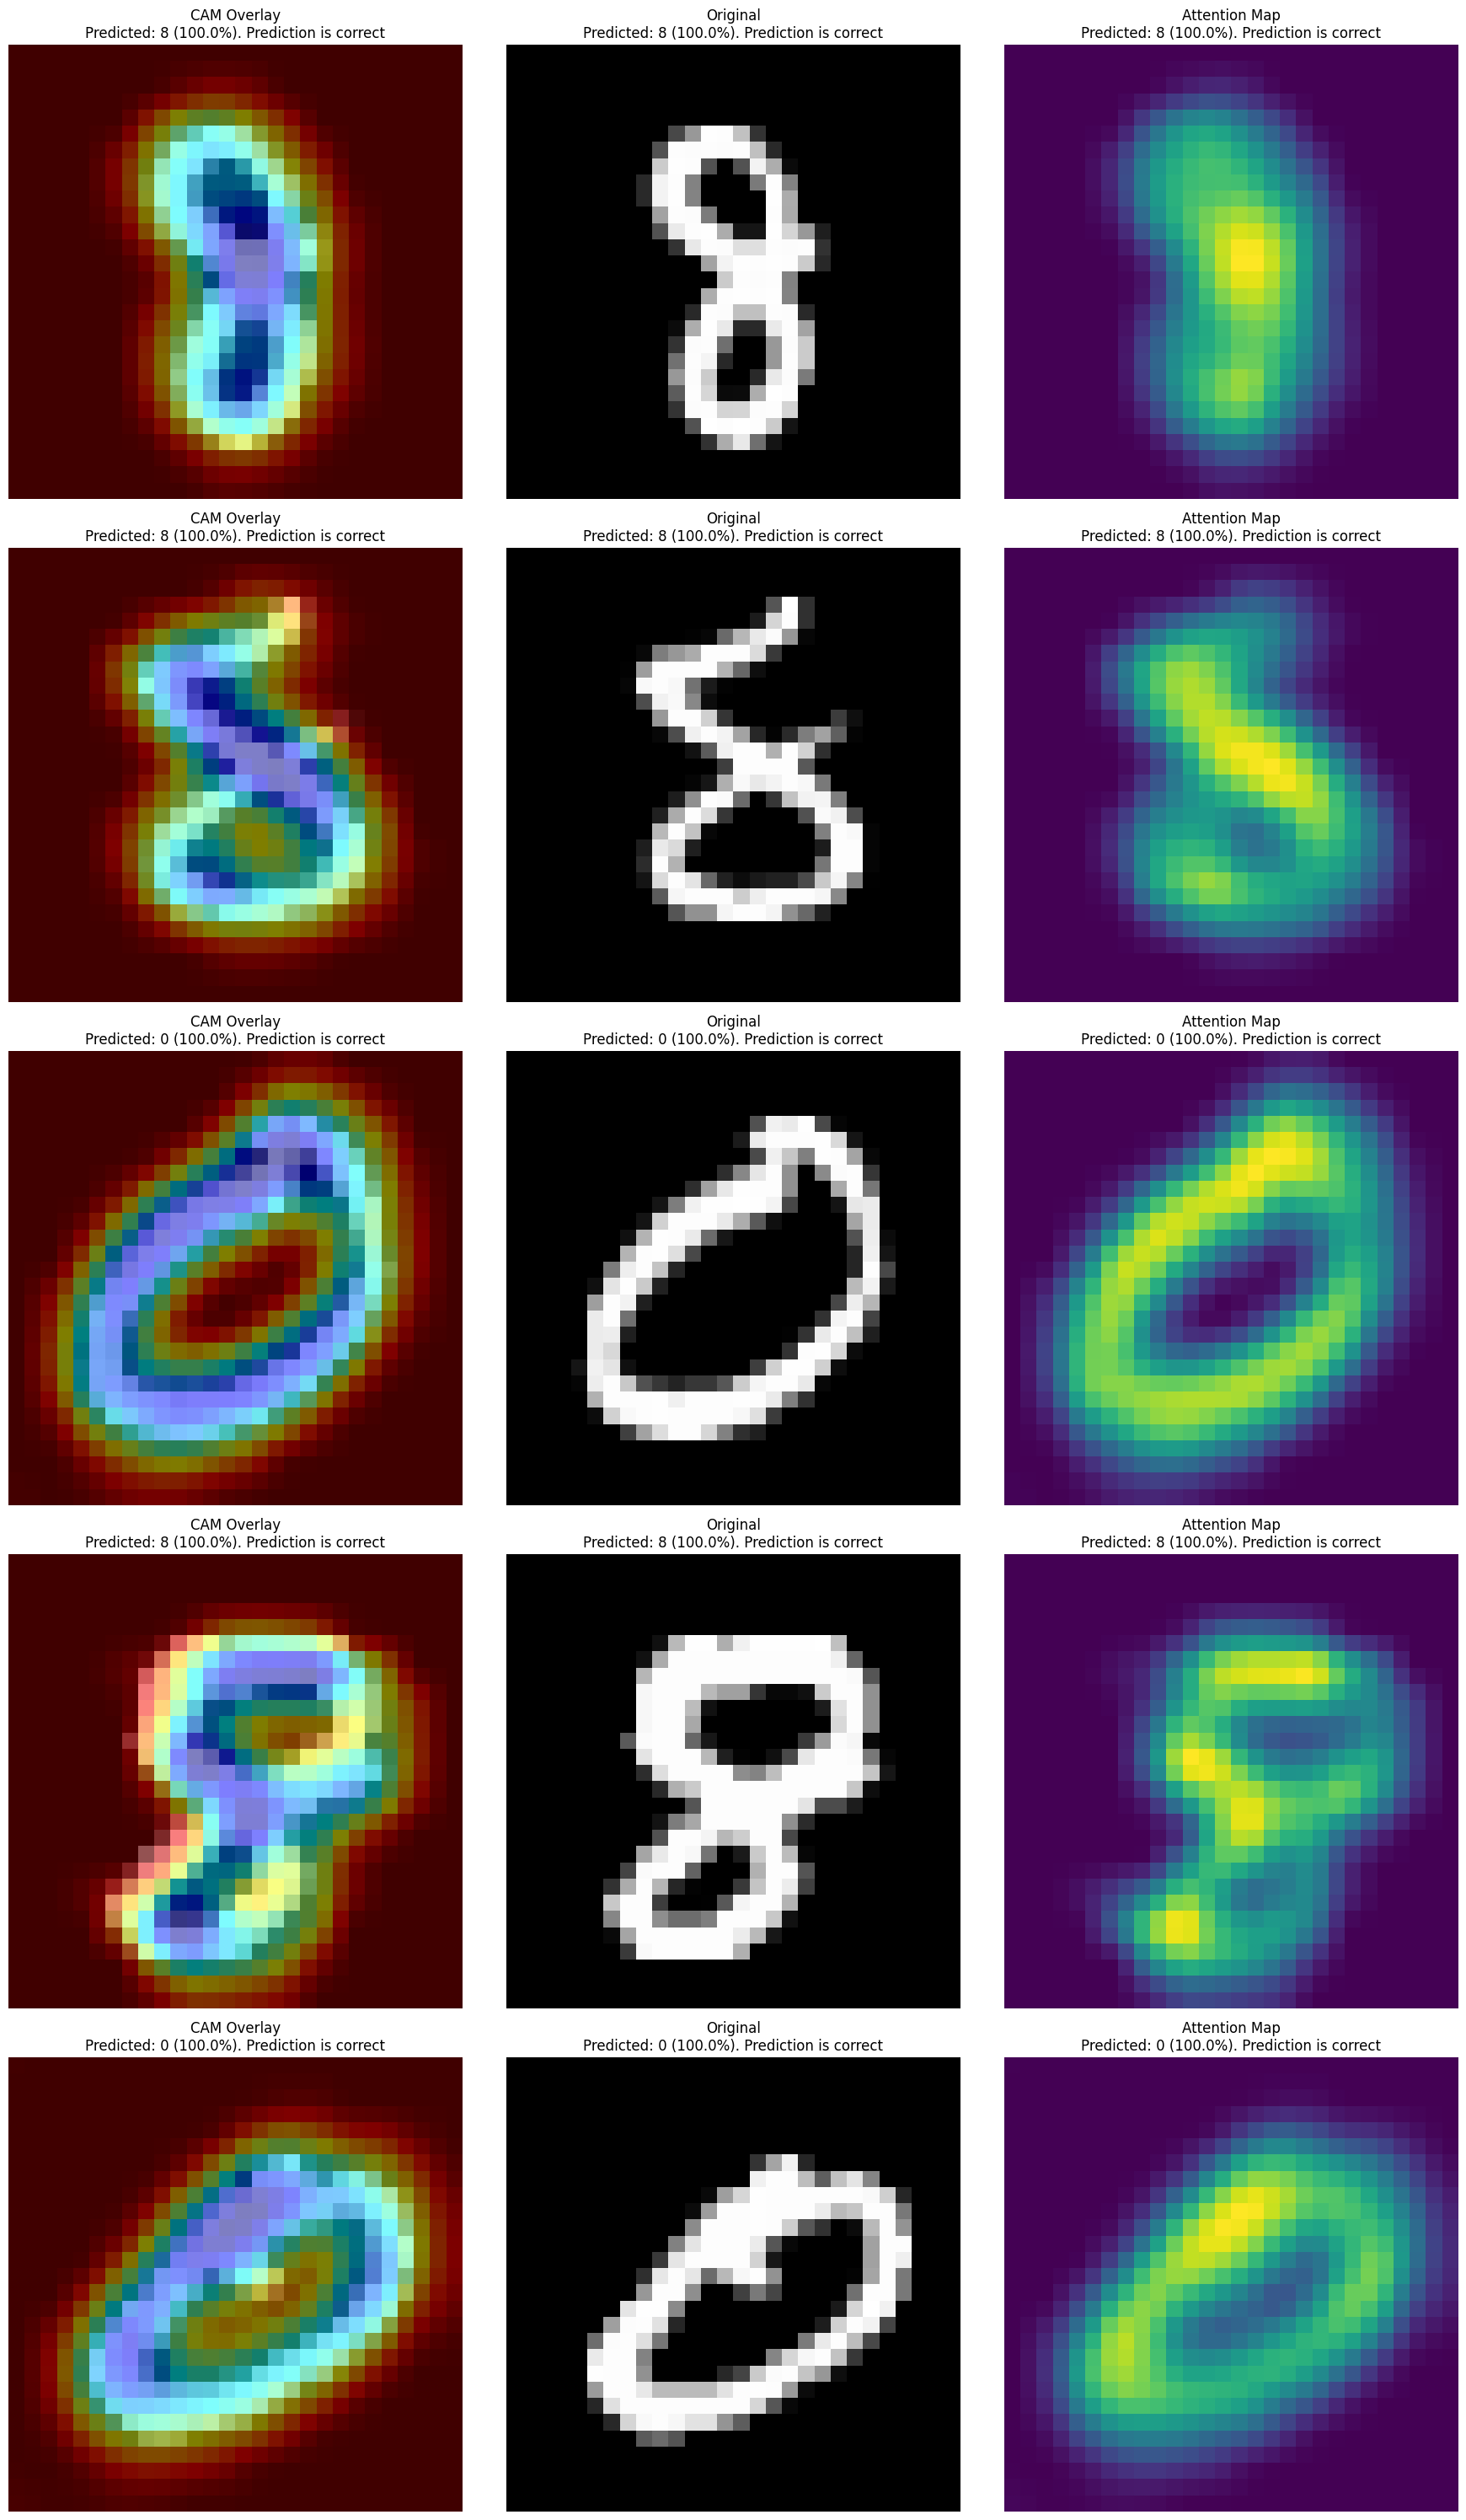

In [98]:
# Second version of gradcam application
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import numpy as np


# define model
# model
# define target layers for grad-cam
#   define a link to the last convolutional layer of the model
last_conv_layer = model[3]
target_layers = [last_conv_layer]

# Number of examples to show
n_examples = 5  # you can change this number

# define input tensor
gradcam_dataloader = DataLoader(ds_train, batch_size=n_examples, shuffle=True)
batch = next(iter(gradcam_dataloader))
examples = batch[0]
targets = batch[1]

# Process all examples
images = []
cam_images = []
grayscale_maps = []
predictions = []
certainties = []
is_correct = []

model.eval()
for index in range(n_examples):
    
    example = examples[index]
    target = targets[index]
    
    # Get prediction
    prediction_probs = model(example.unsqueeze(0).to(device))
    prediction = torch.zeros(num_classes)
    prediction[prediction_probs.argmax()] = 1
    certainty = prediction_probs.max().item() * 100
    
    predictions.append(prediction_probs.argmax().item())
    certainties.append(certainty)
    is_correct.append(all(prediction == target))
    
    print(f"\nExample {index}:")
    print(f"Shape of example: {example.shape}")
    print(f"Target of example: {target}")
    print(f"Predicted target: {prediction} with {certainty}% certainty. Correct? {all(prediction == target)}")

    # Prepare image
    img: numpy.ndarray = example.reshape((28, 28, 1)).repeat(1, 1, 3).numpy()
    images.append(img)

    # Generate GradCAM
    with GradCAM(model=model, target_layers=target_layers) as cam:
        grayscale_cam = cam(input_tensor=example.unsqueeze(0), targets=None, aug_smooth=None, eigen_smooth=None)
        grayscale_cam = grayscale_cam[0, :]
        grayscale_maps.append(grayscale_cam)
        
        cam_image = show_cam_on_image(img, grayscale_cam, use_rgb=False)
        cam_images.append(cam_image)

# Plot all examples
fig, axes = plt.subplots(n_examples, 3, figsize=(18, 6*n_examples))
if n_examples == 1:
    axes = axes.reshape(1, -1)

for idx in range(n_examples):
    # Create title with prediction and certainty
    pred_title = f'Predicted: {labels[predictions[idx]]} ({certainties[idx]:.1f}%). Prediction is {"" if is_correct[idx] else "NOT "}correct'
    
    # First subplot: CAM Overlay
    axes[idx, 0].imshow(cam_images[idx], cmap='viridis')
    axes[idx, 0].set_title(f'CAM Overlay\n{pred_title}')
    axes[idx, 0].axis('off')
    
    # Second subplot: Original Image
    axes[idx, 1].imshow(images[idx], cmap='viridis')
    axes[idx, 1].set_title(f'Original\n{pred_title}')
    axes[idx, 1].axis('off')
    
    # Third subplot: Attention Map
    axes[idx, 2].imshow(grayscale_maps[idx])
    axes[idx, 2].set_title(f'Attention Map\n{pred_title}')
    axes[idx, 2].axis('off')

plt.tight_layout()
plt.show()

# 1.5 Save model weights and other data 

In [99]:
from pathlib import Path
DIR = Path("08_MNIST_output/")
SUBEXPERIMENT_NUM = "02.5" # TODO replace with actual
PREFIX = f"exp_{SUBEXPERIMENT_NUM}_" 

In [100]:
# Save model weights
EXTENSION = ".pth"
weights_filename = PREFIX + "weights" + EXTENSION
torch.save(model.state_dict(), DIR / weights_filename)

In [101]:
# Save the figures
pic_name = (PREFIX + "result.png")
fig.savefig(DIR / pic_name)

In [102]:
# Create md file with details on current subexperiment

# Define the content of the Markdown file
model_architecture = f"""
```python
from torch.nn import Sequential, Conv2d, MaxPool2d, Flatten, ReLU, Linear, Dropout, Softmax

# input: 28X28 images
# output: 3 possible outputs (0: out of problem label, 1: number 0, 2: number 1)

model = Sequential(
    # 1st group
    Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1),
    ReLU(),
    MaxPool2d(kernel_size=2, stride=2),
    # 2nd group
    Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
    ReLU(),
    MaxPool2d(kernel_size=2, stride=2),
    # TODO: maybe 3rd group
    # Flattening into 1d array
    Flatten(),
    # Dense layers (aka Fully-connected layers)
    Linear(in_features=32 * 7 * 7, out_features=128), # maxpooling reduces dimensionality by half, 7 = 28 (image_size) / (2 * 2)
    ReLU(),
    Linear(in_features=128, out_features=num_classes),
    Softmax(dim=1)
)
```
"""

training_description = f"""
- Training data: subset length of **11773**
- ADAM optimizer:
```python
lr = 0.001
adam_opt = Adam(model.parameters(), lr=lr)
```

- Loss function:
```python
loss = nn.CrossEntropyLoss()
```

- Training output:

```
Epoch 1
--------------------
loss: 0.690607 [   64/11773]
loss: 0.333857 [ 6464/11773]
Test Error: 
 Accuracy: 99.0%, Avg loss: 0.323099 

Done!
```
"""

markdown_content = f"""
# Details of the {SUBEXPERIMENT_NUM}th experimentation's results

## Gradcam explanation
![{pic_name}](./{pic_name})

## Model architecture
{model_architecture}

## Training
{training_description}

## Model weights
[model weights](./{weights_filename})
"""

# Write the content to a Markdown file
with open(DIR / (PREFIX + '.md'), 'w') as file:
    file.write(markdown_content)